<table>
    <tr style="background-color:white;">
        <td width="60%">
            <div style="height: 25px;"></div>
            <div align="left" style="color: #4b324e; font-size: 40px; font-weight: bold;">Taller de Qiskit</div>
        </td>
        <td>
            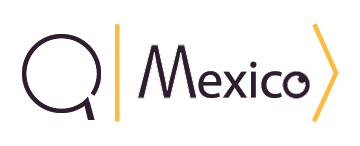
        </td>
    </tr>
</table>

$ \newcommand{\bra}[1]{\langle #1|} $
$ \newcommand{\ket}[1]{|#1\rangle} $
$ \newcommand{\braket}[2]{\langle #1|#2\rangle} $

<div align="center" style="color: #EE2A6F; font-size: 30px; font-weight: bold;">Ruido en los Experimentos</div>

<div align="right" style="font-size: 15px; font-weight: normal;">Preparado por Claudia Zendejas-Morales</div>

<a href="https://opensource.org/licenses/Apache-2.0"></a>

# Contenido

1. [Introducción](#intro)
2. [Sección Uno](#secc1)
   1. [Subsección de Sección Uno](#secc1.1)
   2. [Ejemplo de código](#secc1.2)
   3. [Celdas especiales](#secc1.3)
3. [Sección Dos](#secc2)
   1. [Nombre de los notebooks](#secc2.1)
   2. [Otra Subsección de Sección Dos](#secc2.2)
4. [Sección Tres](#secc3)
   1. [Ligas a los otros notebooks](#secc3.1)

<a id="intro"></a>
# Introducción

intro



## Canal cuántico

En la [teoría de la información cuántica](https://arxiv.org/pdf/quant-ph/0412063.pdf), un canal cuántico es un canal de comunicación que puede transmitir información cuántica, así como información clásica. Un ejemplo de información cuántica es el estado de un qubit. Un ejemplo de información clásica es un documento de texto transmitido a través de Internet.

Más formalmente, los canales cuánticos son mapas de conservación de trazas [completamente positivos](https://en.wikipedia.org/wiki/Completely_positive_map) (CP) entre espacios de operadores. En otras palabras, un **canal cuántico es solo una operación cuántica** vista no solo como la dinámica reducida de un sistema, sino como una tubería destinada a transportar información cuántica. (Algunos autores usan el término "operación cuántica" para incluir también mapas de disminución de trazas mientras reservan el "canal cuántico" para mapas que preservan estrictamente las trazas).

<a id="secc1"></a>
# Ruido en simuladores

Para crear modelos personalizados de ruido para simuladores ruidoso usamos el módulo `noise` de Qiskit Aer, existen 3 clases clave para esto:

- La clase `NoiseModel` que almacena el modelo de ruido para simuladores ruidosos
- La clase `QuantumError` la cual describe los errores de compuerta [CPTP](https://arxiv.org/pdf/quant-ph/0101003.pdf) los cuales pueden ser aplicados tanto antes de una compuerta o una isnrucción de reestablecimeinto (reset), como después de las instruciones de medición
- La clase `ReadoutError` la cual describe de errores de lectura clásicos

In [1]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Kraus, SuperOp
from qiskit.providers.aer import AerSimulator
from qiskit.tools.visualization import plot_histogram

# Import from Qiskit Aer noise module
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import thermal_relaxation_error

<a id="secc1.1"></a>
## Errores cuánticos

En lugar de tratar directamente con el objeto `QuantumError`, existen muchas funciones auxiliares para generar automáticamente un tipo específico de error cuántico parametrizado. Estos están contenidos en el módulo de ruido e incluyen funciones para muchos tipos de errores comunes utilizados en la investigación de la computación cuántica. Los nombres de algunas de las funciones y el tipo de error que devuelven son:

- `pauli_error`: un canal de error de n-qubits de Pauli (matriz unitaria mixta) dado como una lista de Paulis y probabilidades
- `depolarizing_error`: un canal de error de despolarización de n-qubits parametrizado por una probabilidad de despolarización $p$.
- `thermal_relaxation_error`: un canal de relajación térmica de un solo qubit parametrizado por las constantes de tiempo de relajación $T_1$, $T_2$, el tiempo de compuerta $t$ y la población térmica del estado excitado $p_1$.

Para conocer todas las funciones puedes explorar la [API de los Modelos de Ruido](https://qiskit.org/documentation/apidoc/aer_noise.html).

### Combinación de errores cuánticos

Las instancias de `QuantumError` se pueden combinar mediante el uso de composición, producto tensorial y expansión tensorial (producto tensorial de orden inverso) para producir nuevos `QuantumErrors` como:

- Composición: $\mathcal{E}(\rho) = \mathcal{E}_2\left(\mathcal{E}_1\left(\rho\right)\right)$ como `error = error1.compose(error2)`
- Producto tensorial: $\mathcal{E}(\rho) = \left(\mathcal{E}_1\otimes\mathcal{E}_2\right)\left(\rho\right)$ como `error error1.tensor(error2)`
- Expansión tensorial: $\mathcal{E}(\rho) = \left(\mathcal{E}_2\otimes\mathcal{E}_1\right)\left(\rho\right)$ como `error error1.expand(error2)`

### Ejemplo

Por ejemplo, para construir un $5\%$ de error de cambio de bit de un solo qubit:

In [2]:
# Construir un bit-flip de 1 qubit y errores de cambio de fase
p_error = 0.05
bit_flip = pauli_error([('X', p_error), ('I', 1 - p_error)])
phase_flip = pauli_error([('Z', p_error), ('I', 1 - p_error)])
print(bit_flip)
print(phase_flip)

QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.05, QasmQobjInstructions = [[{'name': 'x', 'qubits': [0]}]
  P(1) = 0.95, QasmQobjInstructions = [[{'name': 'id', 'qubits': [0]}]
QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.05, QasmQobjInstructions = [[{'name': 'z', 'qubits': [0]}]
  P(1) = 0.95, QasmQobjInstructions = [[{'name': 'id', 'qubits': [0]}]


In [3]:
# Componer dos errores de inversión de bits y de fase
bitphase_flip = bit_flip.compose(phase_flip)
print(bitphase_flip)

QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.0025000000000000005, QasmQobjInstructions = [[{'name': 'x', 'qubits': [0]}, {'name': 'z', 'qubits': [0]}]
  P(1) = 0.0475, QasmQobjInstructions = [[{'name': 'x', 'qubits': [0]}]
  P(2) = 0.0475, QasmQobjInstructions = [[{'name': 'z', 'qubits': [0]}]
  P(3) = 0.9025, QasmQobjInstructions = [[{'name': 'id', 'qubits': [0]}]


In [4]:
# Producto tensor: errores de inversión de dos bits e inversión de fase 
# con inversión de bits en qubit-0, inversión de fase en qubit-1
error2 = phase_flip.tensor(bit_flip)
print(error2)

QuantumError on 2 qubits. Noise circuits:
  P(0) = 0.0025000000000000005, QasmQobjInstructions = [[{'name': 'x', 'qubits': [0]}, {'name': 'z', 'qubits': [1]}]
  P(1) = 0.0475, QasmQobjInstructions = [[{'name': 'z', 'qubits': [1]}]
  P(2) = 0.0475, QasmQobjInstructions = [[{'name': 'x', 'qubits': [0]}]
  P(3) = 0.9025, QasmQobjInstructions = [[{'name': 'id', 'qubits': [1]}]


<a id="secc1.2"></a>
### Conversión a operadores QuantumChannel

También podemos convertir entre objetos `QuantumError` de Qiskit Aer y objetos `QuantumChannel` de Qiskit Terra.

In [5]:
# Convertir a operador Kraus
bit_flip_kraus = Kraus(bit_flip)
print(bit_flip_kraus)

Kraus([[[ 9.74679434e-01+0.j,  0.00000000e+00+0.j],
        [-1.20234617e-16+0.j,  9.74679434e-01+0.j]],

       [[ 2.62045272e-16+0.j,  2.23606798e-01+0.j],
        [ 2.23606798e-01+0.j, -2.84112242e-16+0.j]]],
      input_dims=(2,), output_dims=(2,))


In [6]:
# Convertir a superoperador
phase_flip_sop = SuperOp(phase_flip)
print(phase_flip_sop)

SuperOp([[1. +0.j, 0. +0.j, 0. +0.j, 0. +0.j],
         [0. +0.j, 0.9+0.j, 0. +0.j, 0. +0.j],
         [0. +0.j, 0. +0.j, 0.9+0.j, 0. +0.j],
         [0. +0.j, 0. +0.j, 0. +0.j, 1. +0.j]],
        input_dims=(2,), output_dims=(2,))


In [7]:
# Convertir de nuevo a un error cuántico
print(QuantumError(bit_flip_kraus))

# La conversión de cheques es equivalente al error original
QuantumError(bit_flip_kraus) == bit_flip

QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.049999999999999996, QasmQobjInstructions = [[{'name': 'x', 'qubits': [0]}]
  P(1) = 0.9500000000000001, QasmQobjInstructions = [[{'name': 'id', 'qubits': [0]}]


True

# Referencias

- []

<table width="100%">
    <tr style="background-color:white;">
        <td>
            <div style="text-align: left;">
            <a href="03_Dispositivo_Real.ipynb" style="color: #EE2A6F; font-size: 15px; font-weight: normal;">
                &lt;&lt; Notebook anterior: 03_Dispositivo_Real
            </a>
            </div>
        </td>
    </tr>
</table>